# VMO2 Coverage Comparisons


In [61]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
%load_ext google.cloud.bigquery
project_id ='prj-vo-aa-p-data-science-exp'

# Data sources

### FDM Competitor Info

Focus here is on postcodes, so we'll have to use the weekly version of the data which has more postcodes

In [3]:
%%bigquery competitor_prices_weekly --project $project_id

-- about 2500 postcodes in this one, but only 3 providers
SELECT
    * EXCEPT(package_name),
    TRIM(package_name) AS package_name -- avoid leading whitespace
FROM `prj-vm-p-data-cdh-01.vodata_fdm.competitor_regional_offers_weekly`
WHERE offer_date = (SELECT max(offer_date) FROM `prj-vm-p-data-cdh-01.vodata_fdm.competitor_regional_offers_weekly`)


Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
# more convenient date format
competitor_prices_weekly.offer_date = competitor_prices_weekly.offer_date.astype('datetime64[ns]')

# the prices are still in £x.xx format (have asked for floats, but that change is not implemented yet)
price_cols = ['all_in_one_monthly_1_price_inc_promo', 'promo_price_2', 'total_standard_monthly_cost', 'upfront_fee', 'voucher_value', 'average_contract_monthly_cost']

competitor_prices_weekly[price_cols] = competitor_prices_weekly[price_cols].replace('[£,]', '', regex=True).astype(float)



### Overbuild status

In [5]:
%%bigquery overbuild --project $project_id

    SELECT
        UPPER(TRIM(postcode)) AS postcode, 
        COALESCE(vm_postcode, 0) AS vm_presence_ind,  -- # same format as the competitor columns, just to make things easier
        households,
        vm_tech,

        overbuild,
        bt_overbuild,
        alt_net_overbuild,
        bt_best_tech_offered,

        competitors.bt_presence_ind,
        competitors.cityfibre_presence_ind,
        competitors.sky_presence_ind,
        competitors.talktalk_presence_ind,
        competitors.vodafone_presence_ind,

        reporting_year_month
        
    FROM `prj-vo-aa-p-cdh-prod.data_enablement_models.staging_overbuild_alternative_network_by_postcode`

    WHERE reporting_year_month  = (SELECT max(reporting_year_month) FROM `prj-vo-aa-p-cdh-prod.data_enablement_models.staging_overbuild_alternative_network_by_postcode`) 


Query is running:   0%|          |

Downloading:   0%|          |

In [36]:
# for joining to FDM data
overbuild.postcode = overbuild.postcode.astype('str')

# Nexfibre

In [7]:
%%bigquery nexfibre --project $project_id

-- we'll take postcodes with a flag and assume every other one is excluded
SELECT DISTINCT postcode, nexfibre_flag
FROM `prj-vo-aa-p-ds-customer-prod.prospect_datasets.prp_prospect_datasets_serviceable_premises_enhanced`
WHERE nexfibre_flag = 1

Query is running:   0%|          |

Downloading:   0%|          |

In [37]:
nexfibre.postcode = nexfibre.postcode.astype('str')

In [9]:
nexfibre

postcode  nexfibre_flag
0       ME3 9LF              1
1      BT51 3NF              1
2      NE42 5EN              1
3      FK10 2RL              1
4      KA20 4BP              1
...         ...            ...
37661   HD8 8PH              1
37662  NP44 6EJ              1
37663  BA21 5UA              1
37664  EH31 2DP              1
37665  YO11 2LR              1

[37666 rows x 2 columns]

### Join the data

In [10]:
vm_postcodes = overbuild.query("vm_presence_ind == 1").set_index('postcode').join(nexfibre.set_index('postcode'), how='left').fillna(0).reset_index()

In [11]:
vm_postcodes

postcode  vm_presence_ind  households  vm_tech  overbuild  \
0        OL7 0NZ                1          21  2 cable          1   
1        M34 3PZ                1          21  2 cable          1   
2       DE21 4BD                1           0  2 cable          1   
3        OL7 9HW                1          20  2 cable          1   
4        OL7 0DN                1           0  2 cable          1   
...          ...              ...         ...      ...        ...   
748403   DY8 5SG                1          10  2 cable          0   
748404   PO1 5FG                1          15  2 cable          0   
748405    B9 4BX                1           6  2 cable          0   
748406  WA16 8HJ                1          13  2 cable          0   
748407  AL10 0SL                1           8  2 cable          0   

        bt_overbuild  alt_net_overbuild bt_best_tech_offered  bt_presence_ind  \
0                  0                  1               2 fttc                1   
1                  0                  1               2 fttc                1   
2                  0                  1               2 fttc                1   
3                  0                  1               2 fttc                1   
4                  0                  1               2 fttc                1   
...              ...                ...                  ...              ...   
748403             0                  0              3 gfast                1   
748404             0                  0              3 gfast                1   
748405             0                  0              3 gfast                1   
748406             0                  0              3 gfast                1   
748407             0                  0              3 gfast                1   

        cityfibre_presence_ind  sky_presence_ind  talktalk_presence_ind  \
0                            0                 1                      1   
1                            0                 1                      1   
2                            0                 1                      1   
3                            0                 1                      1   
4                            0                 1                      1   
...                        ...               ...                    ...   
748403                       0                 1                      1   
748404                       0                 1                      1   
748405                       0                 1                      1   
748406                       0                 1                      1   
748407                       0                 1                      1   

        vodafone_presence_ind  reporting_year_month  nexfibre_flag  
0                           1                202311              0  
1                           1                202311              0  
2                           1                202311              0  
3                           1                202311              0  
4                           1                202311              0  
...                       ...                   ...            ...  
748403                      0                202311              0  
748404                      0                202311              0  
748405                      0                202311              0  
748406                      0                202311              0  
748407                      0                202311              0  

[748408 rows x 15 columns]

### What pct of existing customers are in Nexfibre areas?

Nexfibre data above is churned customers, so we'll just use it as a list of postcodes.

In [12]:
%%bigquery customer_postcodes --project $project_id

WITH
active_customers AS (
  SELECT
    icoms_account_uid,
    customer_account_status_code 

  FROM `prj-vo-aa-p-data-modellin-uat.data_modelling_base.icoms_customer_master_base` 
  WHERE customer_account_status_code IN ('A', 'Active')
),

customer_lookup AS (

    SELECT 
        customer_id.customer_account_id,
        customer_id.icoms_account_number,
        customer_id.icoms_account_uid,
        customer_id.icoms_premises_id,
        customer_id.icoms_premises_uid
    FROM `prj-vo-aa-p-data-modellin-prod.data_modelling.customer`

),
postcodes AS (

    SELECT
        icoms_id.icoms_premises_uid,
        premises_location.postcode,
    FROM
        `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

)
SELECT
  ac.*,
  c.icoms_premises_uid,
  p.postcode


FROM active_customers ac

  LEFT JOIN customer_lookup c 
  ON ac.icoms_account_uid = c.icoms_account_uid

  LEFT JOIN postcodes p 
  ON p.icoms_premises_uid = c.icoms_premises_uid 


Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
customer_postcodes = customer_postcodes.set_index('postcode').join(nexfibre.set_index('postcode'), how="left").fillna(0).reset_index()
customer_postcodes = customer_postcodes[customer_postcodes.postcode != None]

In [14]:
customer_postcodes

postcode  icoms_account_uid customer_account_status_code  \
0         ... ...         5515722801                            A   
1        0L11 3JA         5515155901                            A   
2               2         3352982701                            A   
3        3C1Y 0SG         5512480502                            A   
4               4         3353270901                            A   
...           ...                ...                          ...   
8421286      None        30888133303                            A   
8421287      None         7711313001                            A   
8421288      None        31851339701                            A   
8421289      None        20549516102                            A   
8421290      None        28306105106                            A   

         icoms_premises_uid  nexfibre_flag  
0                  55157228              0  
1                  55151559              0  
2                  33529827              0  
3                  55124805              0  
4                  33532709              0  
...                     ...            ...  
8421286                   0              0  
8421287                   0              0  
8421288                   0              0  
8421289                   0              0  
8421290                   0              0  

[8421291 rows x 5 columns]

In [15]:
# joining customers to premises to postcode introduces some duplicates. 
high_end = customer_postcodes.groupby("icoms_account_uid").nexfibre_flag.max().reset_index()
low_end = customer_postcodes.groupby("icoms_account_uid").nexfibre_flag.min().reset_index()

In [16]:
customer_postcodes.icoms_account_uid.nunique()

6378647

In [17]:
customer_postcodes.groupby("icoms_account_uid").size()

icoms_account_uid
1010000002     1
1010001003     1
1010001205     1
1010001503     1
1010001601     1
              ..
31915222301    1
31915222701    1
31915223001    1
31915223701    2
31915224301    1
Length: 6378647, dtype: int64

In [18]:
high_end.nexfibre_flag.value_counts(normalize=True)

0    0.995695
1    0.004305
Name: nexfibre_flag, dtype: Float64

In [19]:
low_end.nexfibre_flag.value_counts()

0    6351187
1      27460
Name: nexfibre_flag, dtype: Int64

### For postcodes we service with Nexfibre: what is our coverage vs altnets?

About 35% of the Nexfibre postcodes are overbuild by an altnet.

Looking at Cityfibre specifically, about 10% of Nexfibre postcodes are overbuilt.

In [25]:
vm_postcodes.query("nexfibre_flag == 1").alt_net_overbuild.value_counts(normalize=False)

0    14245
1     7776
Name: alt_net_overbuild, dtype: Int64

In [27]:
vm_postcodes.query("nexfibre_flag == 1").cityfibre_presence_ind.value_counts(normalize=True)

0    0.90727
1    0.09273
Name: cityfibre_presence_ind, dtype: Float64

### For postcodes we service with Nexfibre: what is our coverage vs BT?

Almost all Nexfibre areas (>99%) have BT.

In [48]:
vm_postcodes.query("nexfibre_flag == 1").bt_presence_ind.value_counts(normalize=True)

1    0.99942
0    0.00058
Name: bt_presence_ind, dtype: Float64

### What is BT's best-tech-offered in Nexfibre areas?

In [49]:
bt_vs_nf = overbuild.set_index('postcode').join(nexfibre.set_index('postcode'), how="inner").fillna(0).reset_index()[['bt_presence_ind', 'bt_best_tech_offered', 'nexfibre_flag']]

In [53]:
pd.crosstab(
    bt_vs_nf.bt_best_tech_offered,
    bt_vs_nf.nexfibre_flag,
    normalize=False
)

nexfibre_flag             1
bt_best_tech_offered       
0                        16
1 fttp                19210
2 fttc                16733
3 gfast                1524
5 adsl                  136
8 unknown                 3
9 none                    5

### Do we see useul patterns in SQI?

In [54]:
%%bigquery service_quality --project $project_id

WITH 
service_quality AS (

  SELECT
    prediction_date, 
    mac_address, 
    icoms_account_uid, 
    cpe_description, 
    score,
    model_version, 
    is_null_samknows,
    is_null_plume

  FROM prj-vo-aa-p-feature-store-prod.ds_network_sqi.s_ml_sqi_scores
  WHERE prediction_date = DATE_SUB(CURRENT_DATE, INTERVAL 1 DAY)

),

customer_lookup AS (

    SELECT 
        customer_id.customer_account_id,
        customer_id.icoms_account_number,
        customer_id.icoms_account_uid,
        customer_id.icoms_premises_id,
        customer_id.icoms_premises_uid
    FROM `prj-vo-aa-p-data-modellin-prod.data_modelling.customer`

),
postcodes AS (

    SELECT
        icoms_id.icoms_premises_uid,
        premises_location.postcode,
    FROM
        `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

)
SELECT
  sq.*,
  c.icoms_premises_uid,
  p.postcode


FROM service_quality sq

  LEFT JOIN customer_lookup c 
  ON sq.icoms_account_uid = c.icoms_account_uid

  LEFT JOIN postcodes p 
  ON p.icoms_premises_uid = c.icoms_premises_uid 

Query is running:   0%|          |

Downloading:   0%|          |

In [55]:
service_quality

prediction_date   mac_address  icoms_account_uid     cpe_description  \
0            2024-01-16  1835d19ae0a3        22743644601  VM HUB 3.0 (ARRIS)   
1            2024-01-16  48d3439c623b        28331096403  VM HUB 3.0 (ARRIS)   
2            2024-01-16  acf8cc94db51        31898437501  VM HUB 3.0 (ARRIS)   
3            2024-01-16  acf8cc94db51        31898437501  VM HUB 3.0 (ARRIS)   
4            2024-01-16  400d10b09e83        25400384804  VM HUB 3.0 (ARRIS)   
...                 ...           ...                ...                 ...   
7330868      2024-01-16  1835d1cd860b        14221890005  VM HUB 3.0 (ARRIS)   
7330869      2024-01-16  400d1098aab3         7707128602  VM HUB 3.0 (ARRIS)   
7330870      2024-01-16  400d1098aab3         7707128602  VM HUB 3.0 (ARRIS)   
7330871      2024-01-16  c005c28b4473        20480943902  VM HUB 3.0 (ARRIS)   
7330872      2024-01-16  acf8cc578471        11240216701  VM HUB 3.0 (ARRIS)   

            score model_version  is_null_samknows  is_null_plume  \
0        0.994105            25                 0              0   
1        0.945336            25                 0              0   
2        0.995305            25                 0              0   
3        0.995305            25                 0              0   
4        0.833275            25                 0              0   
...           ...           ...               ...            ...   
7330868  0.964242            25                 0              0   
7330869  0.951756            25                 0              0   
7330870  0.951756            25                 0              0   
7330871  0.984401            25                 0              0   
7330872  0.974815            25                 0              0   

         icoms_premises_uid  postcode  
0                 227436446   WD3 7PJ  
1                 283310964   G66 1AE  
2                 318984375   CV1 3EJ  
3                 318984375   CV1 3EJ  
4                 254003848  CF24 2NN  
...                     ...       ...  
7330868           142218900   UB8 3LP  
7330869            77071286  BS15 1JD  
7330870            77071286  BS15 1JD  
7330871           204809439  PO15 7DY  
7330872           112402167  EH15 2QZ  

[7330873 rows x 10 columns]

In [58]:
mean_postcode_sqi = service_quality.groupby('postcode').score.mean().sort_values()

/var/folders/pq/1pygt1_j2fn4w2qq_zh70bdh0000gp/T/ipykernel_41007/2927017950.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Text(0.5, 1.0, 'Mean Service Quality Index Across Postcodes')

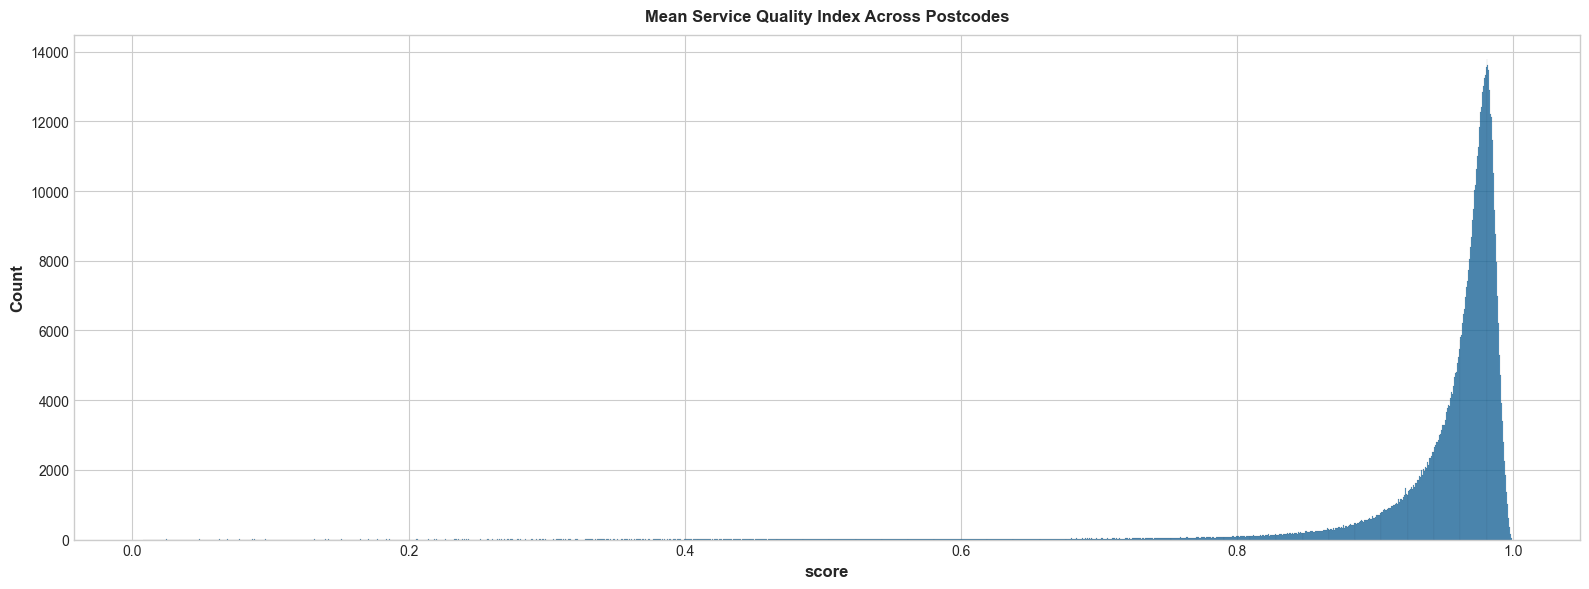

In [65]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(16,6),
    titlesize=12,
    titleweight="bold",
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize=12,
    titleweight="bold",
    titlesize=12,
    titlepad=10,
)

plt.rc(
    "legend",
    fontsize=12
)

plot_params = dict(
    color="0.75",
    style="._",
    markeredgecolor="0.25",
    marketfacecolor="0.25",
    legend=True
)


sns.histplot(mean_postcode_sqi)
plt.title('Mean Service Quality Index Across Postcodes')

# By region

In [ ]:
# do competitor prices vary by region?
......where is region data?


# CL question

In [75]:
%%bigquery openreach --project $project_id

WITH 
postcodes AS (

SELECT
    icoms_id.icoms_premises_uid,
    premises_location.postcode,
FROM
    `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

), 
overbuild AS (

SELECT
    UPPER(TRIM(postcode)) AS postcode, 
    vm_postcode,
    households,
    government_region,
    competitors.bt_presence_ind,
    competitors.cityfibre_presence_ind,
    competitors.sky_presence_ind,
    competitors.talktalk_presence_ind,
    competitors.vodafone_presence_ind,
    
FROM `prj-vo-aa-p-cdh-prod.data_enablement_models.staging_overbuild_alternative_network_by_postcode`

-- get the latest data (2 months behind)
WHERE reporting_year_month  = (SELECT max(reporting_year_month) FROM `prj-vo-aa-p-cdh-prod.data_enablement_models.staging_overbuild_alternative_network_by_postcode`) 
)

SELECT *
FROM overbuild

Query is running:   0%|          |

Downloading:   0%|          |

In [76]:
openreach

postcode  vm_postcode  households government_region  bt_presence_ind  \
0         FY1 3EA            0          18        North West                1   
1          W6 9LR            0           0            London                1   
2        DE14 1JE            0          14     West Midlands                1   
3         PR7 7LJ            0           0        North West                1   
4         FY1 1DH            1           8        North West                1   
...           ...          ...         ...               ...              ...   
1734804   MK8 9DD            0          12        South East                1   
1734805  MK43 9QS            0          16   East of England                0   
1734806  RM17 5FN            0          20   East of England                0   
1734807   TA6 4GY            0          30        South West                0   
1734808   EX1 3ES            0          10        South West                0   

         cityfibre_presence_ind  sky_presence_ind  talktalk_presence_ind  \
0                             0                 1                      1   
1                             0                 1                      1   
2                             0                 1                      1   
3                             0                 1                      1   
4                             0                 1                      1   
...                         ...               ...                    ...   
1734804                       1                 1                      1   
1734805                       0                 1                      1   
1734806                       0                 1                      1   
1734807                       0                 1                      1   
1734808                       0                 1                      1   

         vodafone_presence_ind  
0                            0  
1                            1  
2                            1  
3                            1  
4                            0  
...                        ...  
1734804                      1  
1734805                      0  
1734806                      0  
1734807                      0  
1734808                      0  

[1734809 rows x 9 columns]

In [95]:
provider_households = (openreach
                       .set_index(['postcode', 'government_region', 'households'])
                       .stack()
                       .reset_index()
                       .rename(columns={'level_3': 'provider', 0:'presence_flag'})
                       .assign(
                           num_households = lambda df: df.households * df.presence_flag
                       ))
                     

In [97]:


provider_households

postcode government_region  households                provider  \
0         FY1 3EA        North West          18             vm_postcode   
1         FY1 3EA        North West          18         bt_presence_ind   
2         FY1 3EA        North West          18  cityfibre_presence_ind   
3         FY1 3EA        North West          18        sky_presence_ind   
4         FY1 3EA        North West          18   talktalk_presence_ind   
...           ...               ...         ...                     ...   
10231615  EX1 3ES        South West          10         bt_presence_ind   
10231616  EX1 3ES        South West          10  cityfibre_presence_ind   
10231617  EX1 3ES        South West          10        sky_presence_ind   
10231618  EX1 3ES        South West          10   talktalk_presence_ind   
10231619  EX1 3ES        South West          10   vodafone_presence_ind   

          presence_flag  num_households  
0                     0               0  
1                     1              18  
2                     0               0  
3                     1              18  
4                     1              18  
...                 ...             ...  
10231615              0               0  
10231616              0               0  
10231617              1              10  
10231618              1              10  
10231619              0               0  

[10231620 rows x 6 columns]

In [108]:
provider_households.groupby(['government_region', 'provider']).num_households.sum().reset_index(name='num_households').pivot(index='government_region', columns='provider', values='num_households').assign(total=lambda df: df.sum(1))

provider                  bt_presence_ind  cityfibre_presence_ind  \
government_region                                                   
East Midlands                     2157003                  293556   
East of England                   2767609                  319353   
London                            3507080                       0   
North East                        1262173                  111259   
North West                        3367710                   55839   
Northern Ireland                   836960                       0   
Scotland                          2699666                  491311   
South East                        4007664                  411876   
South West                        2603646                  206819   
Wales                             1450820                       0   
West Midlands                     2564460                  262535   
Yorkshire and The Humber          2293677                  476097   

provider                  sky_presence_ind  talktalk_presence_ind  \
government_region                                                   
East Midlands                      1977421                2008527   
East of England                    2488741                2543240   
London                             3425873                3425222   
North East                         1204548                1205825   
North West                         3201395                3235933   
Northern Ireland                    645326                 661975   
Scotland                           2332955                2345553   
South East                         3666301                3789789   
South West                         2221983                2316699   
Wales                              1273891                1291426   
West Midlands                      2360907                2400732   
Yorkshire and The Humber           2163733                2189056   

provider                  vm_postcode  vodafone_presence_ind       total  
government_region                                                         
East Midlands                 1296879                 867501   8600887.0  
East of England               1388775                1308450  10816168.0  
London                        2568832                2374792  15301799.0  
North East                     815466                 377323   4976594.0  
North West                    2071212                1575147  13507236.0  
Northern Ireland               446717                   4755   2595733.0  
Scotland                      1351194                1180494  10401173.0  
South East                    2040386                2121920  16037936.0  
South West                    1067538                 792762   9209447.0  
Wales                          449535                 235344   4701016.0  
West Midlands                 1648508                1294948  10532090.0  
Yorkshire and The Humber      1420654                1113268   9656485.0